In [1]:
import os
import scipy.io as scio
import pandas as pd
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import numpy as np
import math
from skyfield.api import EarthSatellite,load, wgs84
from skyfield.elementslib import osculating_elements_of
from pytz import timezone
from matplotlib.colors import cnames
from tqdm import tqdm
from multiprocessing import Pool
import statsmodels.api as sm
from matplotlib.pyplot import MultipleLocator

UTC = timezone('UTC')


### No need to run

In [8]:
starttime=datetime.strptime("2022-4-1 0:0:0","%Y-%m-%d %H:%M:%S")
endtime=datetime.strptime("2022-7-20 0:0:0","%Y-%m-%d %H:%M:%S")
delta_time=(endtime-starttime).days*24*3600+(endtime-starttime).seconds
times=[starttime+timedelta(seconds=i) for i in range(0,delta_time,3600)]
# data_decay=np.load('./data/position_height_lat_long_41_719_decay_1409.npy',allow_pickle=True).item()
# data_no_decay=np.load('./data/position_height_lat_long_41_719_based_on_updated_tle_1409.npy',allow_pickle=True).item()
# orbit=pd.read_csv('./data/starlink-1409.csv')
max_isl_length=5014

In [3]:
def get_isl_length_list(data,satid,nabor):
    isl=[]
    position1=data[satid]['position']
    position2=data[nabor]['position']
    for i in range(len(position1)):
        isl.append(math.sqrt((position1[i][0]-position2[i][0])**2+(position1[i][1]-position2[i][1])**2+(position1[i][2]-position2[i][2])**2))
    return isl

In [4]:
sat_1541=np.load('./data/sat_1541.npy')
sat_1541=sat_1541.astype('int64')
grid_topo=np.load('./data/topology_grid.npy')

isl_data_decay={}
isl_data_no_decay={}

for satid in tqdm(orbit['sat'],desc="generating isl data"):
    orbit_index=list(orbit[orbit['sat']==satid]['No.orbit'])[0]
    isl_data_decay[satid]={}
    isl_data_no_decay[satid]={}
    sat_index=np.where(sat_1541==satid)
    nabor_index=np.where(grid_topo[sat_index][0]==1)
    nabors=sat_1541[tuple(nabor_index)]
    for nabor in nabors:
        if list(orbit[orbit['sat']==nabor]['No.orbit'])[0]==orbit_index:
            flag='intra'
        else:
            flag='inter'
        isl_length_list=get_isl_length_list(data_decay,satid,nabor)
        isl_data_decay[satid][nabor]=[flag,isl_length_list]
        isl_length_list=get_isl_length_list(data_no_decay,satid,nabor)
        isl_data_no_decay[satid][nabor]=[flag,isl_length_list]

generating isl data: 100%|██████████| 1409/1409 [01:04<00:00, 21.82it/s]


### Start from this line

In [9]:
starttime=datetime.strptime("2022-4-1 0:0:0","%Y-%m-%d %H:%M:%S")
endtime=datetime.strptime("2022-7-20 0:0:0","%Y-%m-%d %H:%M:%S")
delta_time=(endtime-starttime).days*24*3600+(endtime-starttime).seconds
times=[starttime+timedelta(seconds=i) for i in range(0,delta_time,3600)]
isl_data_decay = np.load('./data/isl_data_decay.npy',allow_pickle=True).item()
isl_data_no_decay = np.load('./data/isl_data_no_decay.npy',allow_pickle=True).item()
max_isl_length=5014

  0%|          | 0/1 [00:00<?, ?it/s]/root/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


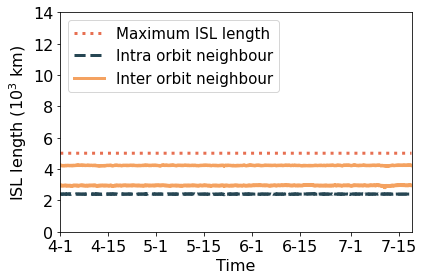

In [10]:
# V2版本数据第一项是inter/intra区分轨內轨间,如需跑v1数据,改v1版本代码
for sat in tqdm(list(isl_data_no_decay.keys())[1:2]):
    c=['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51']
    
    plt.subplots(figsize=(6, 4))
    label_flag_intra=1
    label_flag_inter=2
    plt.plot(times,[max_isl_length/1000 for _ in range(len(times))],label='Maximum ISL length',lw=3,c=c[4],linestyle=':')
    for nabor in isl_data_decay[sat].keys():
        if isl_data_decay[sat][nabor][0]=='intra':
            if label_flag_intra==1:
                plt.plot(times,[i/1000 for i in isl_data_decay[sat][nabor][1]] ,label='Intra orbit neighbour',lw=3,c=c[0],linestyle='--')
                label_flag_intra=0
            else:
                plt.plot(times,[i/1000 for i in isl_data_decay[sat][nabor][1]],c=c[0],lw=3,linestyle='--')
        else:
            if label_flag_inter==2:
                plt.plot(times,[i/1000 for i in isl_data_decay[sat][nabor][1]] ,label='Inter orbit neighbour',lw=3,c=c[3])
                label_flag_inter=0
            else:
                plt.plot(times,[i/1000 for i in isl_data_decay[sat][nabor][1]],c=c[3],lw=3)
    plt.ylabel('ISL length ($10^3$ km)',fontsize=16)
    plt.ylim(0,14)
    # plt.ylim(2000,6000)
    plt.xlim(starttime,endtime)
    plt.legend(loc='upper left',fontsize=15)
    plt.xticks([starttime,starttime+timedelta(days=15),starttime+timedelta(days=30),starttime+timedelta(days=45),starttime+timedelta(days=60),starttime+timedelta(days=75),starttime+timedelta(days=91),starttime+timedelta(days=106)],['4-1','4-15','5-1','5-15','6-1','6-15','7-1','7-15'],fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("Time",fontsize=16)
    plt.tight_layout()    
    plt.savefig('./figure15a.pdf')
    plt.close()
    
    
    plt.subplots(figsize=(6, 4))
    label_flag_intra=1
    label_flag_inter=2
    plt.plot(times,[max_isl_length/1000 for _ in range(len(times))],label='Maximum ISL length',lw=3,c=c[4],linestyle=':')
    for nabor in isl_data_no_decay[sat].keys():
        if isl_data_no_decay[sat][nabor][0]=='intra':
            if label_flag_intra==1:
                plt.plot(times,[i/1000 for i in isl_data_no_decay[sat][nabor][1]] ,label='Intra orbit neighbour',lw=3,c=c[0],linestyle='--')
                label_flag_intra=0
            else:
                plt.plot(times,[i/1000 for i in isl_data_no_decay[sat][nabor][1]],c=c[0],lw=3,linestyle='--')
        else:
            if label_flag_inter==2:
                plt.plot(times,[i/1000 for i in isl_data_no_decay[sat][nabor][1]] ,label='Inter orbit neighbour',lw=3,c=c[3])
                label_flag_inter=0
            else:
                plt.plot(times,[i/1000 for i in isl_data_no_decay[sat][nabor][1]],c=c[3],lw=3)
    plt.ylabel('ISL length ($10^3$ km)',fontsize=16)
    plt.ylim(0,14)
    # plt.ylim(2000,6000)
    plt.xlim(starttime,endtime)
    plt.legend(loc='upper left',fontsize=15)
    plt.xticks([starttime,starttime+timedelta(days=15),starttime+timedelta(days=30),starttime+timedelta(days=45),starttime+timedelta(days=60),starttime+timedelta(days=75),starttime+timedelta(days=91),starttime+timedelta(days=106)],['4-1','4-15','5-1','5-15','6-1','6-15','7-1','7-15'],fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("Time",fontsize=16)
    plt.tight_layout()    
    plt.savefig('./figure15b.pdf')

    
